In [1]:
import pandas as pd
import numpy as np

# read in data
data_path = '/mnt/inca/ai4sh_data.harmo'
df = pd.read_excel(f'{data_path}/raw_data/Basque/Legacy data Basque forests.xlsx')


In [2]:
df.iloc[0]

Unnamed: 0                                                                         Nº. Registro
Date                                                                                      Fecha
Organic carbon                                                                 Carbono orgánico
Coordinate system                                                         Sistema de referencia
X coordinate (long)                                                         Coordenada X (long)
Y coordinate (lat)                                                           Coordenada Y (lat)
Depth                                                                               Profundidad
Land use                                                                                    Uso
Forest condition                                                                 Estado de masa
Species                                                                        Cultivo/Especie 
Organic matter (WB)                     

In [3]:
df = df.iloc[1::]

temp = pd.DataFrame()

temp['time'] = df['Date']
temp['point_id'] = df['Unnamed: 0']

temp['hzn_top'] = np.nan
temp['hzn_btm'] = np.nan

temp.loc[df['Depth'].isin([20, '0-20','0-20 cm']),'hzn_top'] = 0
temp.loc[df['Depth'].isin([40, '20-40','20-40 cm']),'hzn_top'] = 20

temp.loc[df['Depth'].isin([20, '0-20','0-20 cm']),'hzn_btm'] = 20
temp.loc[df['Depth'].isin([40, '20-40','20-40 cm']),'hzn_btm'] = 40


# property
temp['oc'] = df['Organic matter (WB)']*13/1.72 # % -> g/kg, walkley&black

temp['N'] = df['Total nitrogel (KJELDHAL)']
temp.loc[temp['N'].isna(), 'N'] = df.loc[temp['N'].isna(), 'Total nitrogen (DC)']
temp['N'] = temp['N']*10 # % -> g/kg

temp['clay'] = df['Clay']
temp['silt'] = df['Silt']
temp['sand'] = df['Fine Sand'] + df['Coarse sand']

temp['bulk_density'] = df['Bulk density']

temp['P'] = df['Olsen P']
temp['K'] = df['Available K']
temp['EC'] = df['Electrical conductivity in water (1:5, w/v)']

temp['caco3'] = df['Carbonates']

temp['CEC'] = df['Effective cation exchange capacity (COHEX)']*1.2
# temp.loc[temp['CEC'].isna(),'CEC'] = df.loc[temp['CEC'].isna(),'Effective cation exchange capacity (AI)']

from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:25830", "EPSG:4326", always_xy=True) # basque country UTM zone 30T
temp['lon'], temp['lat'] = transformer.transform(df['X coordinate (long)'], df['Y coordinate (lat)'])

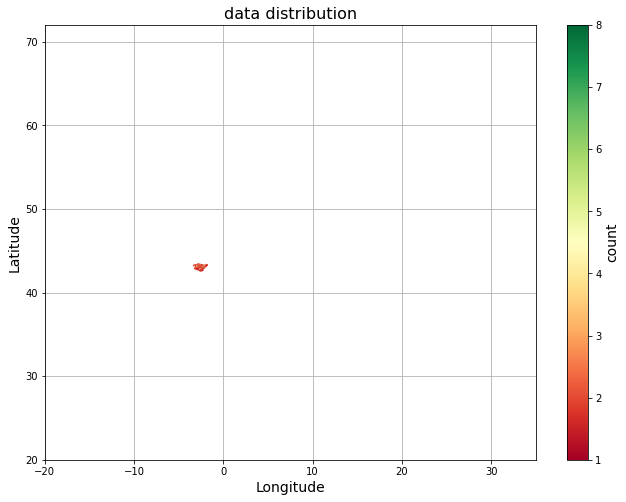

In [4]:
data = temp

import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 8))
hexbin = ax.hexbin(data['lon'], data['lat'], gridsize=50, cmap='RdYlGn', mincnt=1) #, norm=mcolors.LogNorm()
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title(f'data distribution', fontsize=16)

ax.set_ylim([20,72])
ax.set_xlim([-20,35])
colorbar = plt.colorbar(hexbin)
colorbar.set_label(f'count', fontsize=14)

plt.grid(True)
plt.show()

In [5]:
temp['ref'] = 'basque'
temp['nuts0'] = 'ES'

# possible filter
na = temp['time'].isna().sum()
print(f'{na} data with no time info')

na = len(temp[temp['hzn_btm'].isna() | temp['hzn_top'].isna()])
print(f'{na} data with no depth info')

na = len(temp[temp['lat'].isna() | temp['lon'].isna()])
print(f'{na} data with no coordinate info')

print(f'{len(temp)} in total')
temp = temp.dropna(subset=['lat','lon','hzn_top','hzn_btm','time'])

0 data with no time info
1 data with no depth info
0 data with no coordinate info
987 in total


In [6]:
temp.to_csv(f'{data_path}/data/basque_harmonized_v1.csv',index=False)

In [7]:
temp

,time,point_id,hzn_top,hzn_btm,oc,N,clay,silt,sand,bulk_density,P,K,EC,caco3,CEC,lon,lat,ref,nuts0
1,2001,Fraisoro_26_1185,0.0,20.0,22.825581,1.3,29.91,47.26,22.83,0.95,3.15,123.74,NaN,NaN,NaN,-3.026049,43.215893,basque,ES
2,2001,Fraisoro_38_1333,0.0,20.0,38.622093,1.2,26.28,27.14,46.57,NaN,2.45,156.57,NaN,NaN,NaN,-2.842666,42.783559,basque,ES
3,2001,Fraisoro_26_1431,0.0,20.0,12.697674,0.7,10.23,17.12,72.65,NaN,1.78,23.75,NaN,NaN,NaN,-2.695835,42.783256,basque,ES
4,2001,Fraisoro_29_263,0.0,20.0,27.360465,1.4,29.85,28.2,41.96,NaN,1.71,65.99,NaN,NaN,NaN,-2.622408,42.783064,basque,ES
5,2001,Fraisoro_31_265,0.0,20.0,26.377907,1.6,24.68,35.22,40.1,NaN,2.76,89.58,NaN,NaN,NaN,-2.548958,42.782780,basque,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2018,0.18.01173_012.00,20.0,40.0,NaN,1.6,18.75,38.7,42.55,1.36,<2,47,0.13,NaN,7.068,-2.952193,43.216198,basque,ES
984,2018,0.18.00539_006.00,20.0,40.0,NaN,1.7,34.73,44.7,20.57,1.08,<2,54,0.05,NaN,5.532,-2.533411,43.314136,basque,ES
985,2018,0.18.01154_006.00,20.0,40.0,NaN,2.5,20.18,36.35,43.47,0.96,2.90,86,0.07,NaN,11.184,-2.828302,43.405294,basque,ES
986,2018,0.18.01154_010.00,20.0,40.0,NaN,1.4,34.37,30.78,34.85,1.1,<2,175,0.08,NaN,9.588,-2.754440,43.242294,basque,ES
